# Using Pre-trained DenseNet for Aerial Cactus Identification
Dataset from: https://www.kaggle.com/c/aerial-cactus-identification/overview

In [1]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading and processing data  
The datasets loaded here contain only the ID number of the picture and the label (whether it contains a cactus or not). The actual image is contained in a sepparate folder and each file is named after its ID:

In [2]:
# File paths to get Kaggle data
input_path = '../input/'
train_path = input_path + 'train/train/'
test_path = input_path + 'test/test/'

# Load data
train_df = pd.read_csv(input_path + 'train.csv')
sample = pd.read_csv(input_path + 'sample_submission.csv')

# Get ids and labels
train_id = train_df['id']
labels = train_df['has_cactus']
test_id = sample['id']

We also want to get a validation set to get some metrics while training:

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_id, labels, test_size=0.2)

Finally, we need an array containing the actual images. The following function will fetch these images from the ids that we already have:

In [4]:
def fetch_images(ids, filepath):
    # Array to load images into
    arr = []
    for img_id in ids:
        img = plt.imread(filepath + img_id)
        arr.append(img)
        
    # Turn into numpy array and normalize pixel values
    arr = np.array(arr).astype('float32')
    arr = arr / 255
    return arr

In [5]:
# Redefine sets to contain images and not ids
x_train = fetch_images(ids=x_train, filepath=train_path)
x_val = fetch_images(ids=x_val, filepath=train_path)
test = fetch_images(ids=test_id, filepath=test_path)

# Get dimensions of each image
img_dim = x_train.shape[1:]

Lets see what some of these images look like. The resolution is so low (32x32 pixels) that it is hard to understand what the image shows. Intuitively, one can tell that the cacti in the images are shown as white lines:

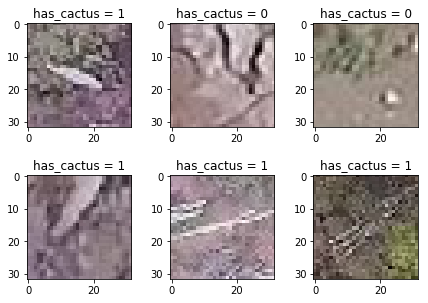

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=3)
ax = ax.ravel()
plt.tight_layout(pad=0.2, h_pad=2)

for i in range(6):
    ax[i].imshow(x_train[i])
    ax[i].set_title('has_cactus = {}'.format(y_train.iloc[i]))

## Building the model
The model will consist of a pre-trained DenseNet, specifically DenseNet201 that consists of 201 layers and was trained using the imagenet dataset. Then it will be followed by a fully connected layer of our own:

In [7]:
# Layers for the full model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, LeakyReLU, Activation
from keras.layers.normalization import BatchNormalization

# Pre-trained model
from keras.applications.densenet import DenseNet201

Using TensorFlow backend.


In [8]:
# Hyperparameters
batch_size = 64
epochs = 30
steps = x_train.shape[0] // batch_size

Here we create the architecture for the model. I like using Keras' Functional API to build the models but using the Sequential approach yields the same results:

In [9]:
# Inputs
inputs = Input(shape=img_dim)

# DenseNet
densenet201 = DenseNet201(weights='imagenet', include_top=False)(inputs)

# Our FC layer
flat1 = Flatten()(densenet201)
dense1 = Dense(units=256, use_bias=True)(flat1)
batchnorm1 = BatchNormalization()(dense1)
act1 = Activation(activation='relu')(batchnorm1)
drop1 = Dropout(rate=0.5)(act1)

# Output
out = Dense(units=1, activation='sigmoid')(drop1)

# Create Model
model = Model(inputs=inputs, outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.
74842112/74836368 [==============================] - 3s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Finally, use `ReduceLROnPlateau` to deal with a plateauing learning rate and `ImageDataGenerator` to make sure our model is trained on different variations of the same picture:

In [10]:
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=2, mode='max')

img_aug = ImageDataGenerator(rotation_range=20, vertical_flip=True, horizontal_flip=True)
img_aug.fit(x_train)

In [11]:
# Show architecture of model
from keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='densenet201_model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
densenet201 (Model)          multiple                  18321984  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               491776    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
__________

## Fitting and getting results

Since we're using `ImageDataGenerator`, we need to fit the model using Keras' `fit_generator()` instead of just `.fit()`:

In [12]:
model.fit_generator(img_aug.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=steps, epochs=epochs, 
                    validation_data=(x_val, y_val), callbacks=[reduce_lr], 
                    verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 131s - loss: 0.0755 - val_loss: 0.0616
Epoch 2/30
 - 57s - loss: 0.0322 - val_loss: 0.0670
Epoch 3/30
 - 58s - loss: 0.0229 - val_loss: 0.1330
Epoch 4/30
 - 58s - loss: 0.0227 - val_loss: 0.0246
Epoch 5/30
 - 57s - loss: 0.0194 - val_loss: 0.0293
Epoch 6/30
 - 57s - loss: 0.0190 - val_loss: 0.2544
Epoch 7/30
 - 57s - loss: 0.0332 - val_loss: 0.2859
Epoch 8/30
 - 57s - loss: 0.0195 - val_loss: 0.0231
Epoch 9/30
 - 58s - loss: 0.0162 - val_loss: 1.2665
Epoch 10/30
 - 56s - loss: 0.0221 - val_loss: 1.8890
Epoch 11/30
 - 57s - loss: 0.0148 - val_loss: 0.0410
Epoch 12/30
 - 56s - loss: 0.0235 - val_loss: 0.0910
Epoch 13/30
 - 57s - loss: 0.0230 - val_loss: 0.0250

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 14/30
 - 58s - loss: 0.0095 - val_loss: 0.0151
Epoch 15/30
 - 57s - loss: 0.0069 - val_loss: 0.0227
Epoch 16/30
 - 56s - loss: 0.0061 - val_loss: 0.0121

Epoch 00016: ReduceLROnPlateau

Finally, get predictions from the model and produce a submission file:

In [13]:
test_pred = model.predict(test, verbose=2)

In [14]:
sample['has_cactus'] = test_pred
sample.to_csv('densenet_model.csv', index=False)